# Descente de gradient

* Faire du machine learning, c'est écrire une fonction dont les réponses dépendent d'une série de paramètres.
    * Par exemple, allez voir les équipes régression logistique ou régression linéaire pour qu'elles vous montre.
    * Cette série de paramètres, on l'appelera toujours "theta" (écrit avec la lettre grecque $\theta$).
    * Si $\theta$ est bien choisi, la fonction donnera des donnes réponses,
    * Sinon la fonction donnera des réponses absurdes qui ne serviront à rien.


* Le "learning" du machine learning, c'est quand on utilise un algorithme pour trouver le bon $\theta$ qui fait que la fonction retourne les bonnes réponses.
    * Le bon $\theta$, c'est celui qui minimise l'erreur de la fonction sur un jeu de données qui sert d'entraînement.

* Dans ce TD, on va voir la **descente de gradient**, qui permet de trouver ce minimum de manière très efficace.
* Sachez que les modèles qui font fureur en ce moment comme ChatGPT ou Midjourney sont entraînés avec un algorithme qui n'est qu'une descente de gradient un peu pimpée. Il s'agit d'un algorithme **vraiment** efficace qui a révolutionné la face du monde.


* La descente du gradient s'appuie sur ce principe très simple : pour trouver le bas d'une fonction il suffit de descendre.
* En mathématiques, quand on a une fonction, on peut aussi calculer sa pente, qui nous dit dans quelle direction ça monte.
* Cette pente s'appelle **gradient**. C'est une flèche dont la direction donne la direction qui monte et dont la taille indique à quel point ça monte.
* Dans ce TD, on ne va pas calculer nous même cette fonction gradient. On va faire appel au module python `autograd` qui fait ça très bien pour nous tant qu'on a tout codé en numpy.


* **Installez `autograd`**. 
    * Une des lignes suivante devrait marcher pour vous, si vous l'écrivez dans la cellule suivante:
    * Sur jupyter notebook: `pip install autograd`
    * Sur VS code: `%pip install autograd`
    * Il faut ensuite relancer votre kernel: menu `Noyau` -> `redémarrer` (en anglais: `Kernel`-> `restart`)

In [2]:
# petit détail, on utilisera dans ce cours 
# une version de numpy spéciale pour autograd.
# mais ça ne change rien pour vous.
import autograd.numpy as np

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Cette fonction là sert juste à tester la correction de vos fonctions
def tester(fun, target, *args):
    try:
        sortie = fun(*args)
    except Exception as e:
        print('Erreur: Votre fonction fait une erreur quand on la lance. Regardez la dernière ligne :')
        raise e
    if sortie is None:
        print('Erreur: Votre fonction ne renvoie rien, vous avez du oublier un return !')
    if sortie is Ellipsis:
        print('Erreur: Votre fonction retourne "...". Vous devez remplacer les trois petits points dans le code.')
    assert np.max(np.abs(sortie-target))<1e-5, 'erreur: {}({}) devrait valoir {}, mais la fonction retourne {}'.format(
    fun.__name__, args, target, sortie)


# 1. La fonction de coût
* Ici, on définit une fonction de coût appelée `get_mse`.
* Elle prend en entrée un `np.array` de taille 2 appelé `theta` et retourne un nombre.
* Le but de ce TD est de trouver le minimum de cette fonction, c'est à dire le `theta` pour lequel la fonction retourne le plus petit nombre.


In [7]:
# Vous n'avez rien à faire dans cette cellule. On définit juste notre fonction de coût
np.random.seed(42)
X = np.random.uniform(3, size=100)
Y = np.random.normal(-170+40*X, 20)

def get_mse(theta:np.array):
    # ici on s'assure juste que X est bien une matrice 
    # quitte à avoir un seul élément par ligne
    if len(X.shape)==1:
        X_reshaped = X.reshape(len(X), 1)
        
    Y_pred = (X_reshaped * theta[1:]).sum(axis=1) + theta[0]
    return ((np.array(Y_pred) - np.array(Y))**2).mean() 


### Ce que vous devrez expliquer aux autres équipes
* Les modèles de prédiction développés par les autres équipes donnent des résultats qui dépendent d'un paramètre `theta`.
* Selon le `theta` choisi, les modèles font plus ou moins d'erreur.
* Ensemble, vous devrez codez une fonction qui mesure cette erreur en fonction de `theta`.
* Puis, grace à ce que vous aurez appris avec ce TD, vous pourrez trouver le `theta` tel que le modèle fera le moins d'erreur possible.

## Illustration
* Ici, on va dessiner la fonction de coût avec laquelle on va travailler.
* Rappel : c'est une fonction qui prend en entrée un `np.array` de taille 2 et qui retourne un nombre.
* On peut donc la représenter comme une carte topographique : `theta[0]` en absisse, `theta[1]` en ordonnée, et la couleur représente le résultat.

In [10]:
# Vous n'avez rien à faire dans cette cellule. Il s'agit juste d'une fonction pour dessiner des lignes de niveau.
    
def plot_mse_profile(ax, lossfun, colorbar=False):
    t1 = ((X-X.mean())*(Y-Y.mean())).sum()/((X-X.mean())**2).sum()
    t0 = Y.mean() - t1*X.mean()
    
    width_theta_1 = 10*abs(t1)
    width_theta_0 = 2*width_theta_1
    mesh_theta_0 = np.arange(t0-width_theta_0, t0+width_theta_0, 2*width_theta_0/50)
    mesh_theta_1 = np.arange(t1-width_theta_1, t1+width_theta_1, 2*width_theta_1/50)
    
    Z = np.array([[np.log(lossfun(np.array([theta_0, theta_1])))
                   for theta_0 in mesh_theta_0] 
                   for theta_1 in mesh_theta_1])

    msemap = ax.contourf(mesh_theta_0, mesh_theta_1,Z,cmap=('OrRd'), levels=50)
    if colorbar:
        plt.colorbar(msemap, label='log(mse)')

    #ax.scatter([t0], [t1], marker='+', c='k', s=500)
    
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('theta[1]')
    ax.set_title('Profile de la MSE en fonction de theta[0] et theta[1]')
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, lossfun=get_mse, colorbar=True)
plt.show()

# 2. Descente de gradient
* On va trouver le minimum de notre fonction de coût en suivant la pente descendante.
* La "pente descendante", c'est l'opposé du gradient.
* Quelques rappels :
    * le gradient est une fonction qui prend un point (ici, on considère que nos données sont fixées et que ce qui peut changer c'est les paramètres, donc un point est un `theta`)
    * Le gradient retourne la **direction** dans laquelle la $MSE$ monte. Il retourne donc un vecteur qui possède autant de dimensions que `theta`.


## 2.1. Définir la fonction gradient
* Pour trouver le gradient de notre fonction de coût, on va utiliser une fonction toute faite, `grad` :

In [14]:
from autograd import grad

* La fonction `grad` prend en paramètre n'importe quelle fonction `f` ne prenant qu'un seul paramètre, et retourne le gradient de `f`
* `grad` retourne donc une fonction.
* Voici un exemple :

In [16]:

# Je définis ma fonction `f`
def f(theta):
    return theta[0]**2 + 56*theta[1]
print('f est un objet de type :')
print(type(f))
print()

# Je demande le gradient de f, que je stocke sous le nom de `gf`.
gf = grad(f)
print('J\'ai demandé grad(f) et je l\'ai stocké dans un truc que j\'ai appelé gf.')
print('gf est un objet de type :')
print(type(gf))
print()
theta_test = np.array([5.,9.])
print('Je définis un theta comme ça pour tester et je demande gf(theta_test). Ça me renvoie :')
print(gf(theta_test))

* Le gradient d'une fonction, c'est une fonction. Je dois donc appeler `gf` comme une fonction normale pour voir quelle valeur elle me retourne.
* C'est un peu la beauté de python : une fonction est un objet comme un autre qui peut être donné en paramètre, retourné comme un résultat... c'est d'une élégance rare.


* Remarquez que `f` prend en entrée quelque chose en 2 dimensions et retourne un seul nombre.
    * "Calculer le gradient d'une fonction $f$" n'a de sens que si $f$ retourne un seul nombre, puisque le gradient donne la direction où ça descend.
* Remarquez aussi que `gf` prend aussi en entrée quelque chose en 2 dimensions, mais retourne quelque chose en 2 dimensions.

* **Demandez le gradient de la fonction `get_mse` avec `grad(get_mse)`**
    * `grad_mse` est donc une fonction qui prend un `theta` et retourne une flèche indiquant par où ça monte.

In [19]:
grad_mse = ...

tester(grad_mse, np.array([175.27213335, 329.73781142]), np.zeros(2))
tester(grad_mse, np.array([181.39141037, 343.04222965]), np.ones(2))
print('Tout bon !')

## 2.2. Initialiser la descente de gradient
* Rappel : la descente de gradient, c'est partir de n'importe où et descendre. Commençons donc par partir de n'importe où.
* **Prenez un `theta` au hasard**
    * Que doit être `theta` ? Un nombre ? Un `np.array` ? De quelle taille ?
    * Attention, `grad` est pénible quand il croit que votre `theta` est un entier. Mettez des nombres à virgule, quitte à ce que ça soit des 0 après la virgule. 
    
    
* Une fourchette de valeurs pour que les visualisations donnent quelque chose :
    * `theta[0]` entre -1000 et 600
    * `theta[1]` entre -300 et 500

In [21]:
theta = ...
print('mon theta:')
print(theta)

* **Affichez votre `theta` par-dessus le profile de la MSE**
    * Indice : utilisez `ax.scatter(absisse, ordonnée)`

In [23]:

fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)  # on plot le profile de la MSE
### YOUR CODE HERE ###
...
######
plt.show()

* Résultat attendu (on s'en fiche de la position exacte du point) :
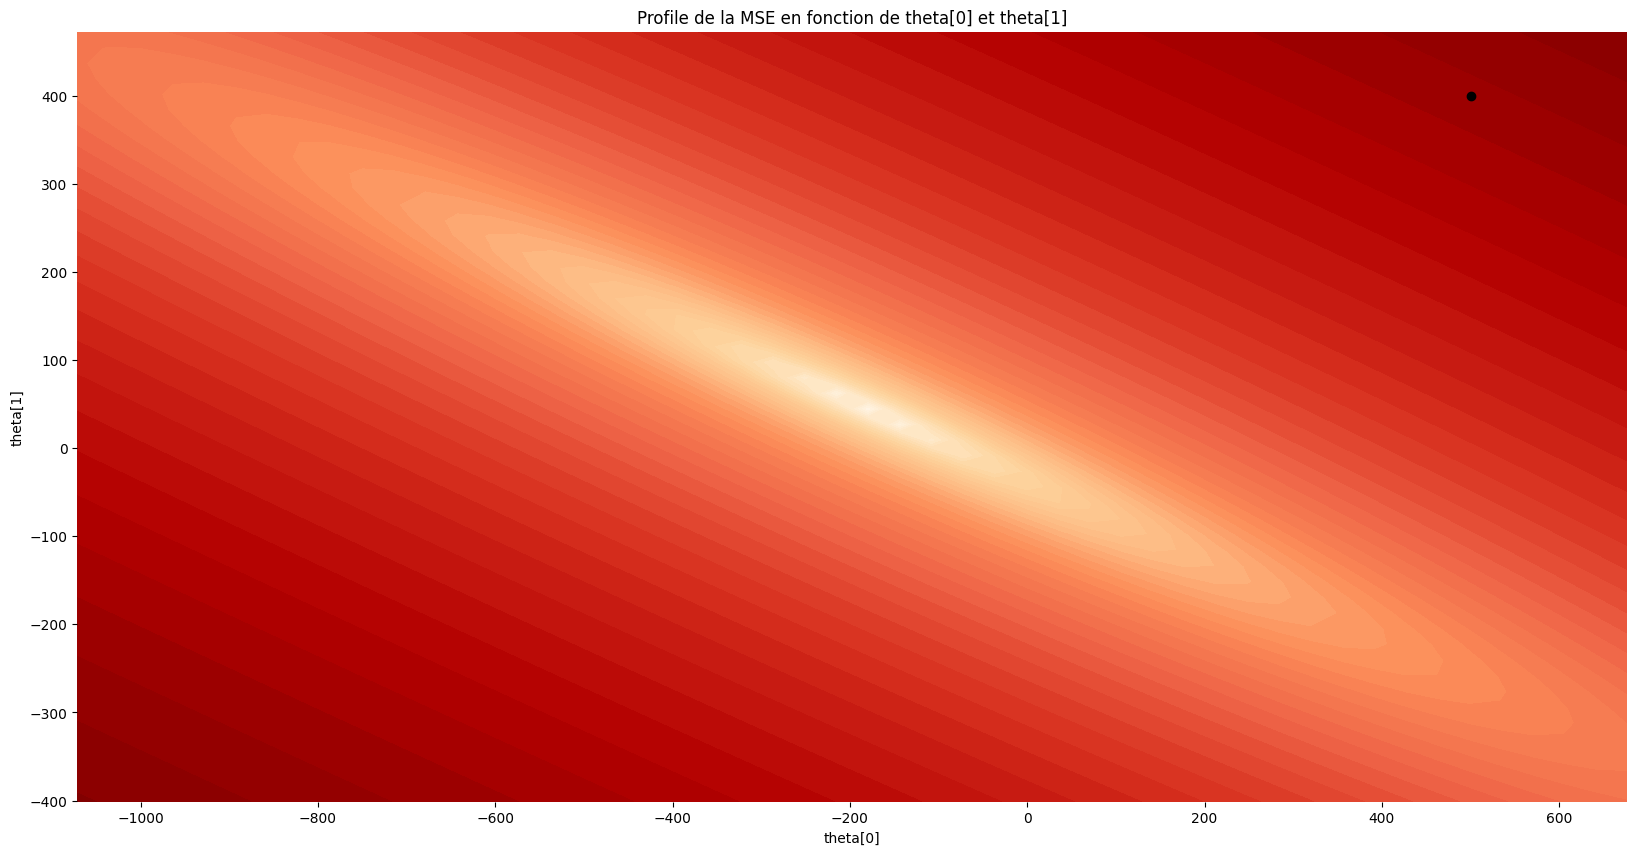

## 2.3. La première étape de descente
* **Calculez le gradient de la $MSE$ en ce point `theta`**
    * Comme vous voyez, le gradient est un vecteur. On l'interpète comme une flèche indiquant par où ça monte.

In [26]:
g = ...
print(g)

* On va trouver un meilleur point à partir de notre point mis au hasard. Pour ça, il suffit de descendre.
* Et pour descendre, il suffit de suivre le gradient dans l'autre sens.


* **Définissez `theta_next`, qu'on obtient en partant de `theta` et en enlevant le gradient en ce point**

In [28]:
theta_next = ...
theta_next

* Résultat attendu : un np.array de taille 2.

* Regardez les valeurs de ce `theta_next`... Il est parti beaucoup trop loin !
* En fait, le gradient donne la direction à suivre **quand on est au point `theta`**, mais il ne faut pas la suivre éternellement.
* On va la suivre pas à pas, en définissant la taille d'un pas `step_size=0.05`
* **Re-définissez `theta_next` comme précédemment, mais cette fois en enlevant seulement `step_size` fois le gradient**

In [31]:
step_size = ...
theta_next = ...
theta_next

* Résultat attendu : un np.array de taille 2, avec des valeurs un peu moins extrêmes.

* Beaucoup mieux.
* **Affichez `theta` et `theta_next` par-dessus le profile de la MSE**

In [34]:

fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)

### YOUR CODE HERE ###
...
######

plt.show()

* Résultat attendu :
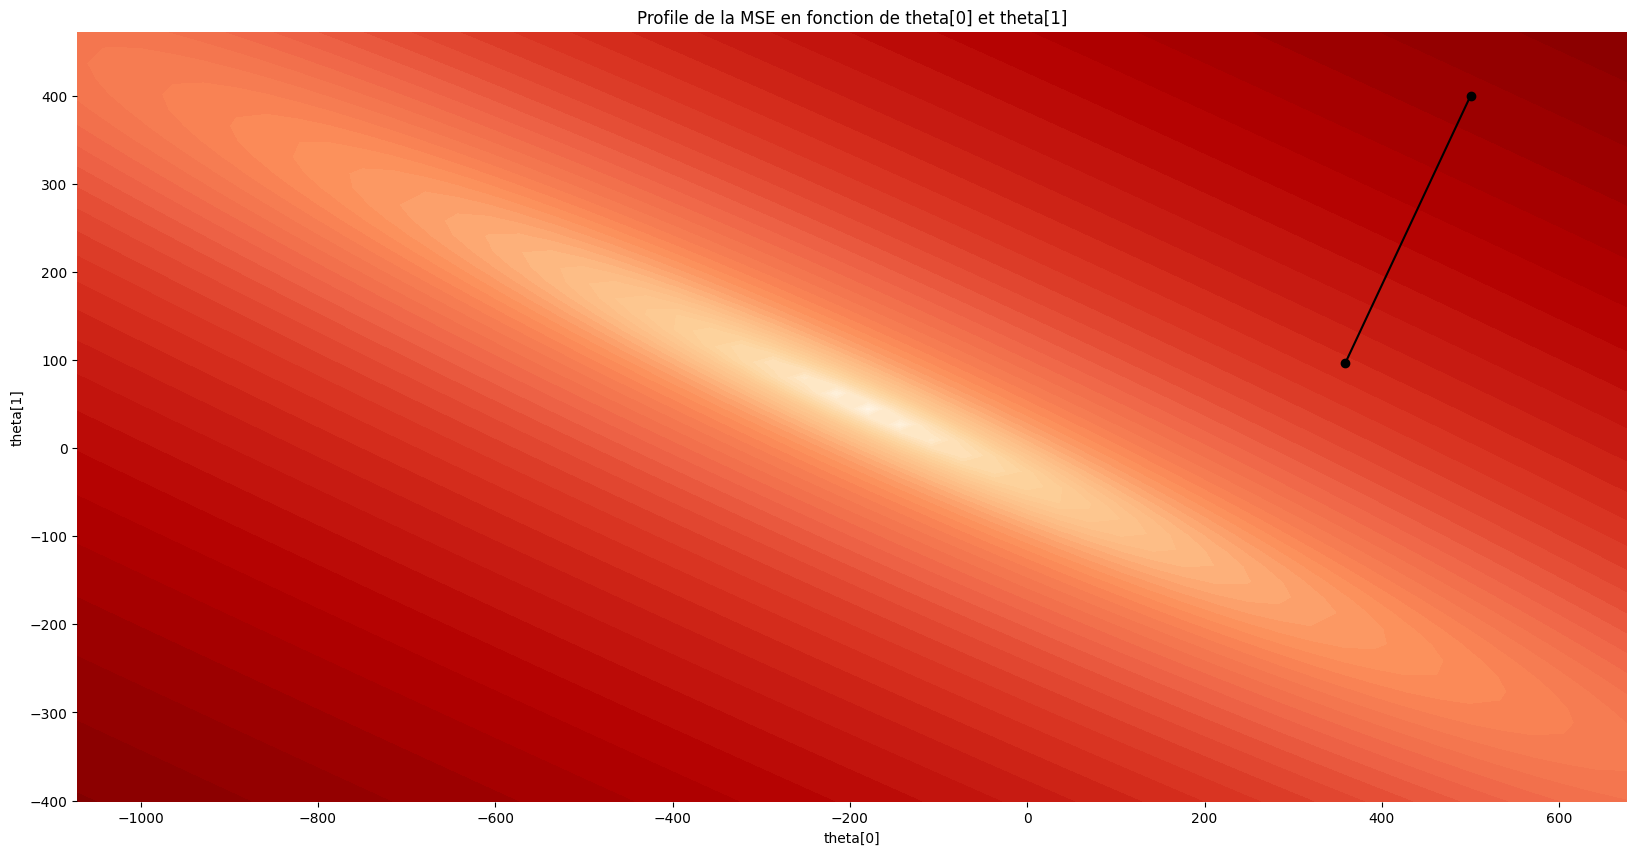

* **Est-ce que `theta_next` est là où vous l'auriez imaginé ?**


* **Quelle est la $MSE$ du premier modèle défini par `theta` ?**
* **Quelle est la $MSE$ du nouveau modèle défini par `theta_next` ?**


* Rappel : pour calculer la $MSE$, on utilise la fonction `get_MSE(Y_pred, Y)`.
    * Pour calculer `Y_pred`, on appelle simplement `reglin(theta, X)` qui nous renvoie toutes les prédictions d'un coup puisque c'est la super implémentation `numpy`
    * Les données d'entrée sont `X`, les labels sont `Y`

In [38]:
mse_prev = ...
print('mse initiale : {:>30.5f}'.format(mse_prev))

mse_next = ...
print('mse après une itération : {:>19.5f}'.format(mse_next))


## 2.4. Descendre jusqu'au bout
* Il s'agit maintenant de faire plusieurs pas.
* **Faites une boucle de 10 itérations :**
    * Partez d'un `theta` que vous mettez où vous voulez. N'oubliez pas de mettre une virgule dedans quand même.
    * À chaque tour de boucle, calculez `grad_mse(theta)` et modifiez votre `theta` en enlevant `step_size*grad_mse(theta)`.
* **Stockez tous les `theta` que vous aurez explorés dans une liste.**

In [40]:
theta = ...
theta_tested = []
for i in range(10000000000):
    theta_tested += ...
    grad_theta = ...
    theta = ...
    if np.max(step_size*grad_theta) < 0.000001:
        break


* **Affichez la trajectoire des `theta` que vous avez explorés**

In [42]:
theta_tested = np.array(theta_tested)  # au cas où ça sera juste une liste. Un np.array, c'est toujours mieux.

fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)
### YOUR CODE HERE ###
...
######
plt.show()

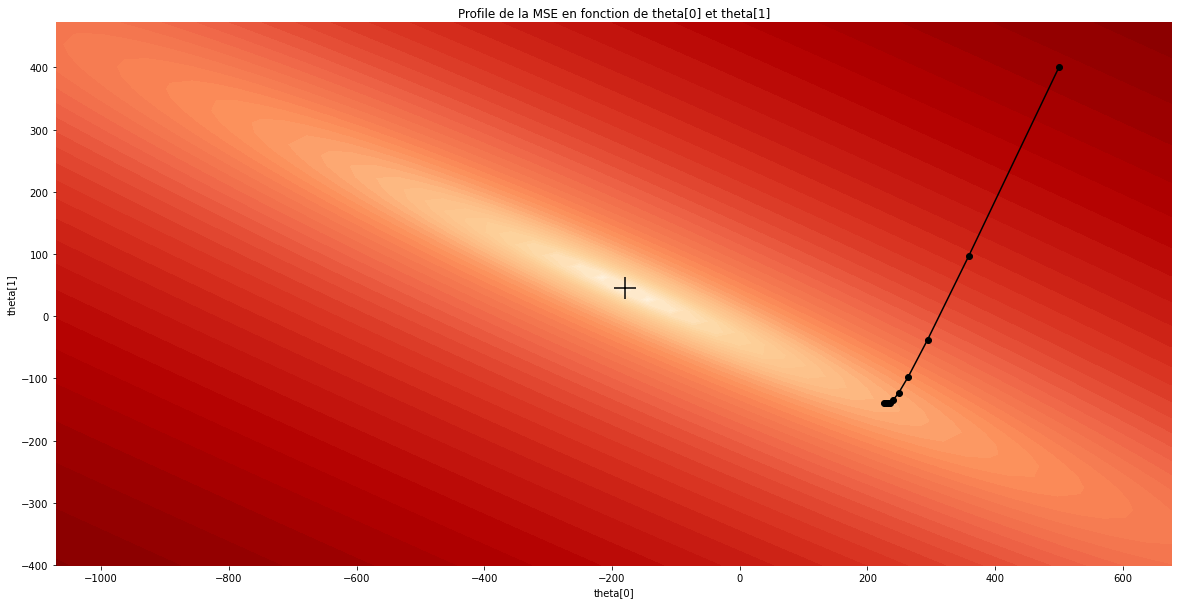

* **Quelle est la MSE de votre dernier `theta` ?**
    * On accède au dernier `theta` de la liste avec `theta_tested[-1]`

In [45]:
best_mse = ...
print('ma dernière MSE : {:.5f}'.format(best_mse))

* **Essayez de faire varier le nombre de pas que vous faites. Que se passe-t-il ?**


In [47]:
fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)

### YOUR CODE HERE ###
...
######
ax.set_title('Descente de gradient avec 1000 itérations')
plt.show()


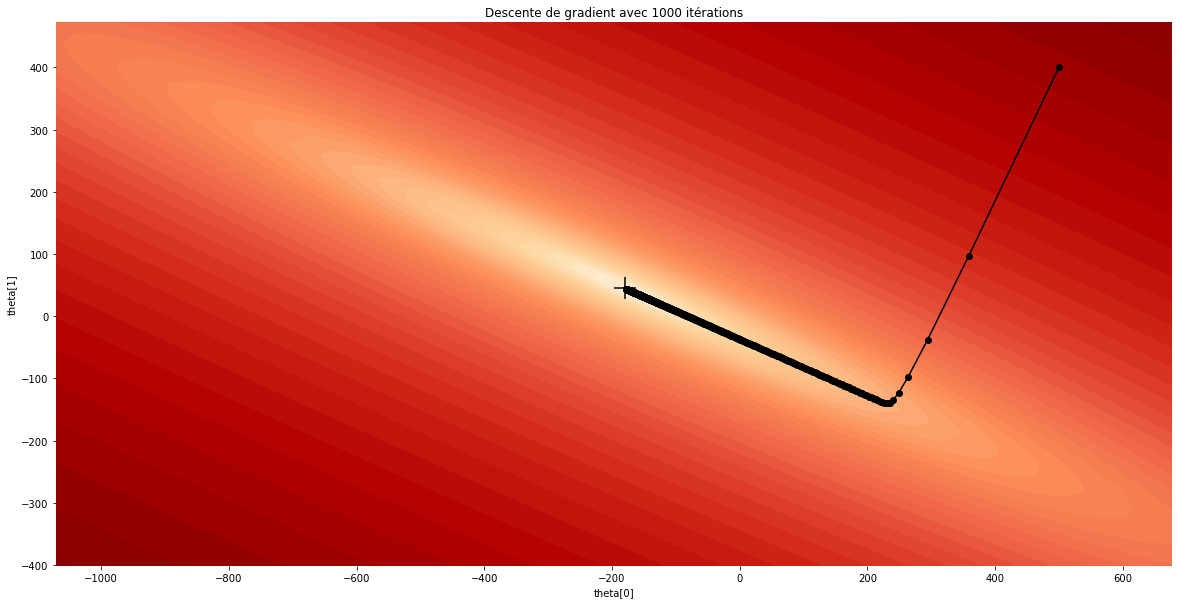

* **Essayez de faire varier le `theta` de départ. Que se passe-t-il ?**


In [50]:
fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)

### YOUR CODE HERE ###
...
######

ax.set_title('Descente de gradient avec 1000 itérations')
plt.show()


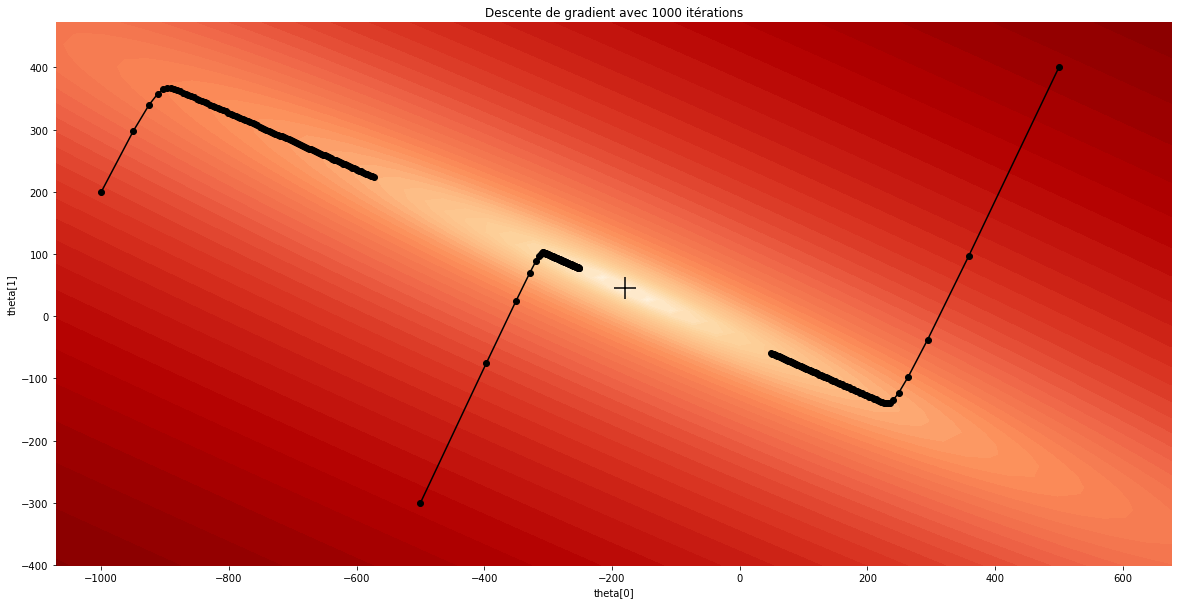

* **Essayez de faire varier `step_size`. Que se passe-t-il ?**


In [53]:
fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)

### YOUR CODE HERE ###
...
######

ax.set_title('Descente de gradient, step_size = 0.15')
plt.show()
print('ma meilleure MSE : {}'.format(get_mse(theta_tested[-1])))

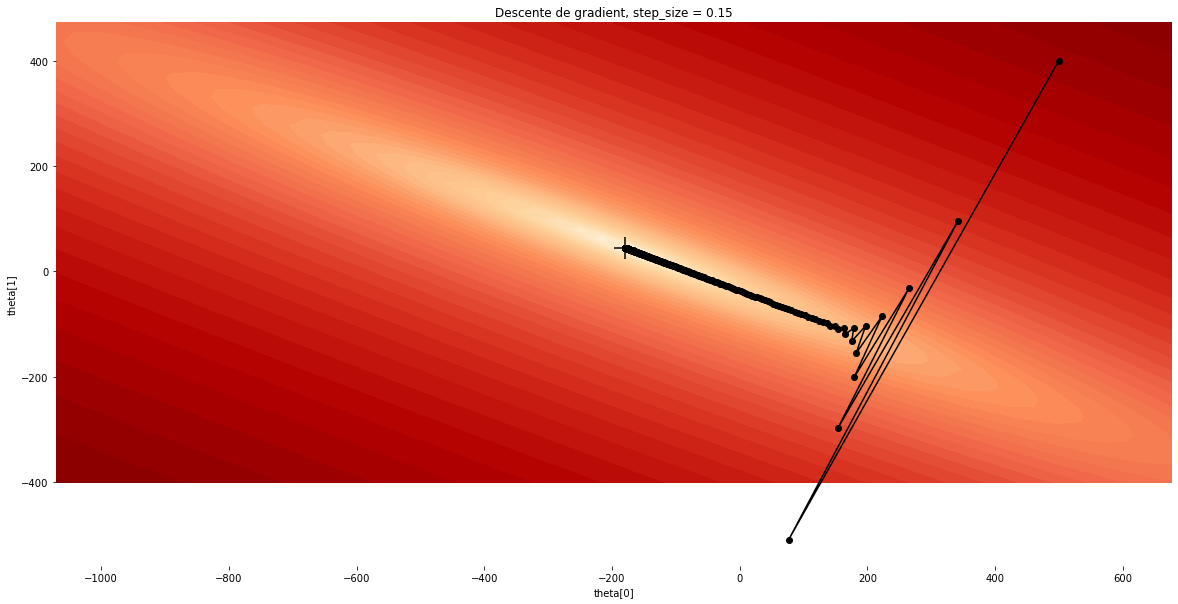

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
plot_mse_profile(ax, get_mse)

### YOUR CODE HERE ###
...
######

ax.set_title('Descente de gradient, step_size = 0.01')
plt.show()
print('ma meilleure MSE : {}'.format(get_mse(theta_tested[-1])))

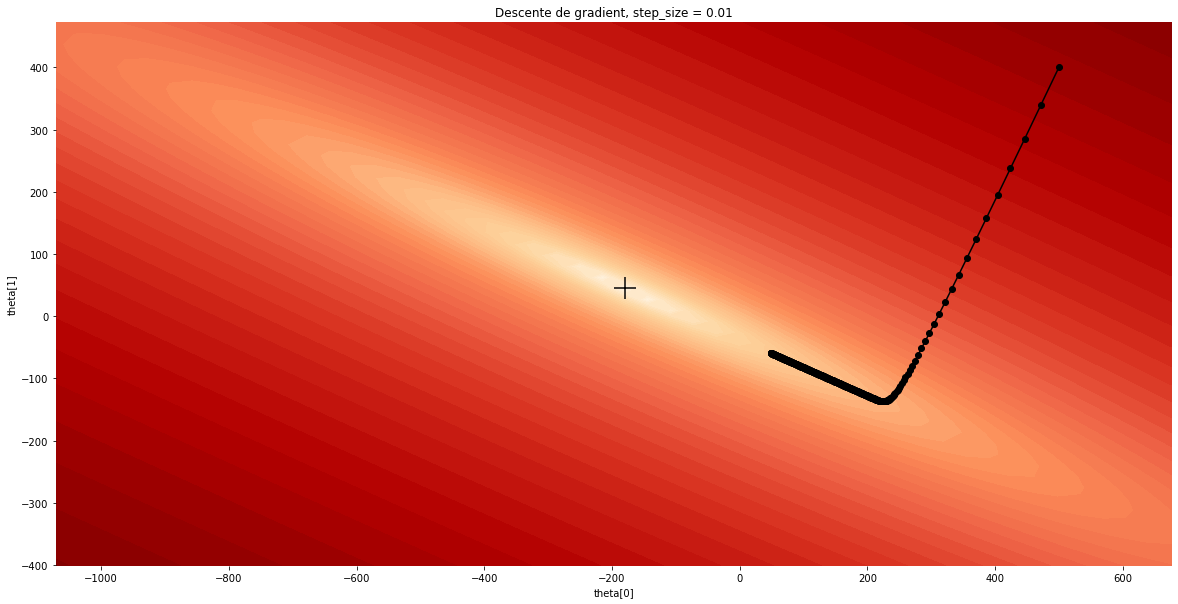

# 3. Gradient descent pour la régression linéaire
* Suivez le notebook d'optimisation de code avant de remplir les cellules suivantes.
* **Chargez les données de la régression linéaire**

In [58]:
data = ...


* **Récupérez la fonction `reglin` codée de manière optimale avec le notebook "Optimisation de code"**

In [60]:
def reglin(theta:np.array, X:np.array):
    # ici on s'assure juste que X est bien une matrice 
    # quitte à avoir un seul élément par ligne
    if len(X.shape)==1:
        X = X.reshape(len(X), 1)
        
    result = ...
    return result


* **Codez la fonction `get_mse(theta)` qui prend en entrée un paramètre `theta` et retourne l'erreur de la régression linéaire de paramètre `theta`**
    * L'équipe "régression linéaire" devrait savoir tous les détails nécessaire à propos de la $MSE$.

In [62]:
def get_mse(theta:np.array):
    ### YOUR CODE HERE ###
    ...
    ######
    mse = ...
    return mse

* **Trouvez le meilleur `theta` avec une descente de gradient**
    * /!\ On rappelle que `theta` est un `np.array` qui contient tous les paramètres du modèle.
    * Pour une régression linéaire, il y a un paramètre de plus que de variables.
    * De quelle taille est le `theta` que vous cherchez ?

* **Donnez vos résultats à l'équipe "régression linéaire" pour qu'ils puissent continuer avec un modèle qui tient la route.**
* S'ils reviennent avec un modèle qui prend plusieurs variable en entrée, que devez-vous changer dans votre descente de gradient ?

# 4. Gradient descent appliquée à la régression logistique
* Suivez le notebook d'optimisation de code avant de remplir les cellules suivantes.

* **Chargez les données du problème de reglog**

In [66]:
data_reglog = ...
data_reglog.head()

* **Récupérez la fonction reglog(theta, X) codée de manière optimisée**


In [68]:
def reglog(theta:np.array, X:np.array):
    ### YOUR CODE HERE ###
    ...
    ######
    

* **Ecrivez la fonction get_mse_reglog(theta) en appelant reglog**

In [70]:
def get_mse_reglog(theta:np.array):
    ### YOUR CODE HERE ###
    ...
    ######
    mse = ...
    return mse

* **Trouvez le meilleur `theta` pour la régression logistique avec une descente de gradient**
    * /!\ On rappelle que `theta` est un `np.array` qui contient tous les paramètres du modèle.
    * Pour une régression logistique, il y a un paramètre de plus que de variables.
    * De quelle taille est le `theta` que vous cherchez ?

# 5. Présentez vos résultats